# Maximum Likelihood Estimation and Limited Dependent Variable Models

*Monday 23, September*

### Content

- [1. Intro to MLE](#1.-Intro-to-MLE)
- [2. Coding the MLE estimator]()
- [3. LDV with `statsmodels`]()

In [24]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mp
%matplotlib nbagg
import matplotlib.pyplot as plt

import statsmodels as sm

Maximum likelihood is an intuitive 

### 2. Coding the MLE estimator 

#### 2.1. The linear case

Let's create a random sample of size $N = 1,000$, generated by the following DGP: $$ \mathbf{y} = \mathbf{X \beta} + \mathbf{\varepsilon} \\ \varepsilon \sim \mathcal{N}(0, \sigma^2 I)$$
The normality of errors and their 0-correlation ensure they are independent, a property we will need to implement the MLE method.

In [189]:
#Defining covariates as linear functions + normal noise to avoid perfect multicolinearity
X0 = np.ones(1000)
X1 = np.linspace(0, 100, 1000) + np.random.normal(loc=0.0, scale = 10, size=1000)
X2 = np.linspace(0, -500, 1000) + np.random.normal(loc=0.0, scale = 50, size=1000)
X3 = np.linspace(0, 2000, 1000) + np.random.normal(loc=0.0, scale = 200, size=1000)
X = np.array([X0,
              X1, 
              X2,
              X3]).T

#True parameters
β = np.array([5, 10, -.5, .25]).T
sigma_sq = 100
epsilon = np.random.normal(loc=0.0, scale = sigma_sq, size=1000)

#Measured and true values
y = X @ β + epsilon
y_true = X @ β

We get a simple linear, homoskedastic relastionship between the covariates and the observed $y_i$. See for instance $\mathbf{y}$ with respect to $\mathbf{x_1}$ below

<IPython.core.display.Javascript object>


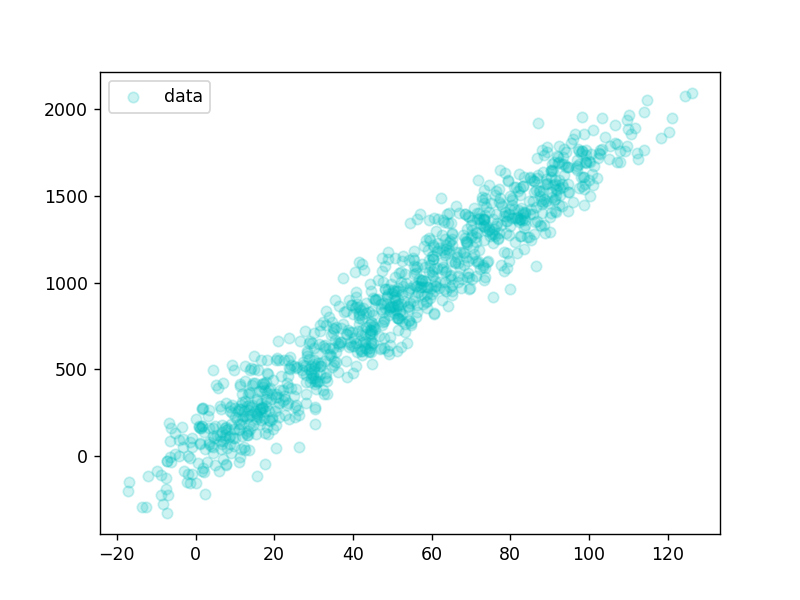

In [192]:
plt.scatter(X1, y, c="c", alpha=0.2, label="data")
plt.legend()

OLS is BLUE in this case. Now if we estimate the coefficients by OLS we get:

In [191]:
β_ols = np.linalg.inv((X.T @ X)) @ (X.T @ y)
β_ols

array([ 3.7008825 ,  9.97827167, -0.56050026,  0.23744393])

Now under normality of errors, OLS and MLE estimates of the coefficients are asymptotically equal. Let's define an iterative procedure to estimate $\boldsymbol{\beta}$ through MLE and verify that the results are in line with OLS. When errors are normally distributed, we do not need to go through such lengths as the MLE estimator has a closed-form solution. But we simply show how the convergence algorithm works in this simple case. 

Our true parameter values are $$\boldsymbol{\beta} = \begin{bmatrix}
                            \alpha \\
                            \beta_1 \\
                            \beta_2 \\
                            \beta_3
                      \end{bmatrix}  = \begin{bmatrix}
                            10 \\
                            5 \\
                            0.5 \\
                            0.25
                      \end{bmatrix}$$
We define a likelihood function $$f\left(\mathbf{y} | \mathbf{X} ; \boldsymbol{\beta}, \sigma^{2}\right)=\prod_{i=1}^{n} f\left(y_{i} | x_i ; \boldsymbol{\beta}, \sigma^{2}\right)$$
where we assume that errors are normally i.i.d, so

$$ f\left(y_{i} | x_i ; \boldsymbol{\beta}, \sigma^{2}\right) = \frac{1}{\sqrt{2 \pi} \sigma} \cdot e^{-\frac{1}{2 \sigma^{2}}\left(y_{i}-x_{i}^{\prime} \boldsymbol{\beta}\right)^{2}} $$

We further define the likelihood function $\mathcal{L}(\boldsymbol{\beta} | \mathbf{y}, \mathbf{X})$ which treats the parameters $\boldsymbol{\beta}$ and $\sigma$ as random and the values $\mathbf{y, X}$ as given. MLE consists in maximising the value of $\mathcal{L}(\boldsymbol{\beta}, \sigma | \mathbf{y}, \mathbf{X})$ by chosing $\boldsymbol{\beta}$ and $\sigma$ optimally. It is easier to work with the log of the likelihood function and this does not affect the maximiser as any monotonically increasing transformation of a function has the same maximiser.

We thus maximise:

$$
\begin{split}
\log{\mathcal{L}(\boldsymbol{\beta}, \sigma | \mathbf{y}, \mathbf{X})} = & \ell\left(\boldsymbol{\beta}, \sigma | \mathbf{y}, \mathbf{X} \right) \\
        = & -\frac{n}{2} \ln (2 \pi)-\frac{n}{2} \ln \left(\sigma^{2}\right)-\frac{1}{2 \sigma^{2}} \sum_{i=1}^{n}\left(y_{i}-x_{i}^{\prime} \beta\right)^{2}
\end{split}
$$

#### 2.2.  Iterative approach to likelihood maximisation

The EM algorithm

In [ ]:
def newton_raphson:
    
    i = 0
    error = 100
    
    while 